### Importing libraries

In [113]:
import pandas as pd
from collections import defaultdict
import math
import numpy as np
from decimal import Decimal
import scipy.ndimage
import matplotlib.pyplot as plt

In [100]:
file_path1 = 'testDataforTOI/amblypiaStudyTest2 Data Export.tsv'
# file_path2 = 'TestData/amblyopiaStudy MetricsSanaTest.tsv'

dataExport = pd.read_csv(file_path1, sep='\t')
# dataMetric = pd.read_csv(file_path2, sep='\t')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)


Checking to find the end of calibration index

In [101]:

dataExport[dataExport.eq("Eyetracker Calibration").any(1)]['Presented Stimulus name']

197     Eyetracker Calibration
198     Eyetracker Calibration
199     Eyetracker Calibration
200     Eyetracker Calibration
201     Eyetracker Calibration
                 ...          
5277    Eyetracker Calibration
5278    Eyetracker Calibration
5279    Eyetracker Calibration
5280    Eyetracker Calibration
5281    Eyetracker Calibration
Name: Presented Stimulus name, Length: 5076, dtype: object

### Extracting features

In [102]:
dataExport = dataExport[["Eyetracker timestamp", "Event", "Event value", "Gaze point X (MCSnorm)", "Gaze point Y (MCSnorm)", "Eye movement type", 
    "Presented Stimulus name", 'AOI hit [slothStimulus-final (1) - sloth1]',
       'AOI hit [slothStimulus-final (1) - sloth2]',
       'AOI hit [slothStimulus-final (1) - sloth3]',
       'AOI hit [slothStimulus-final (1) - sloth4]',
       'AOI hit [slothStimulus-final (1) - sloth5]',
       'AOI hit [slothStimulus-final (1) - sloth6]',
       'AOI hit [slothStimulus-final (1) - sloth7]',
       'AOI hit [slothStimulus-final (1) - sloth8]',
       'AOI hit [slothStimulus-final (1) - sloth9]',
       'AOI hit [slothStimulus-final (1) - sloth10]',
       'AOI hit [slothStimulus-final (1) - sloth11]',
       'AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]',
       'AOI hit [catStimulus-final (1) - cat11]',
        'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 
                         'Gaze point right Y (MCSnorm)']]

#Only isolate non calibration data
dataExportWithoutCalibration = dataExport[5282:]

#Drop all columns with eye movement type of eyes not found
dataExportWithoutCalibration = dataExportWithoutCalibration[dataExportWithoutCalibration['Eye movement type'] != 'EyesNotFound']


#normalizes TIME when the calibration ends and stimulus sloth starts (at 0)
dataExportWithoutCalibration['Eyetracker timestamp'] = dataExportWithoutCalibration['Eyetracker timestamp'] - dataExportWithoutCalibration['Eyetracker timestamp'].iloc[0]

#normalizes TIME when the sloth ends and cats start (at 0)
#find the index where the cat stimulus begins
indices = dataExportWithoutCalibration.index[dataExportWithoutCalibration['Presented Stimulus name'] == "catStimulus-final (1)"]

#Find the beginning time for normalization
beginTime = dataExportWithoutCalibration['Eyetracker timestamp'].loc[8853]
index_of_catBegin = (dataExportWithoutCalibration.index.tolist()).index(indices[0])
onylCat = dataExportWithoutCalibration.index[index_of_catBegin:]
#iterate through all times for cat stimulus and update
for i in onylCat:
    dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp'] = dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp'] - beginTime




### interpolate Data

In [103]:
columns_to_interpolate = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)', 
                          'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)']
# Use the subset parameter to interpolate only the specified columns
dataExportWithoutCalibration[columns_to_interpolate] = dataExportWithoutCalibration[columns_to_interpolate].interpolate(method='linear')
nan_df = dataExportWithoutCalibration.isna()  # or df.isnull()

#isolate only saccade data
mask = dataExportWithoutCalibration["Eye movement type"] == "Saccade"
dfSaccade = dataExportWithoutCalibration[mask]

Eyetracker timestamp                              4
Event                                          6673
Event value                                    6674
Gaze point X (MCSnorm)                            0
Gaze point Y (MCSnorm)                            0
Eye movement type                                 1
Presented Stimulus name                          12
AOI hit [slothStimulus-final (1) - sloth1]     3487
AOI hit [slothStimulus-final (1) - sloth2]     3487
AOI hit [slothStimulus-final (1) - sloth3]     3487
AOI hit [slothStimulus-final (1) - sloth4]     3487
AOI hit [slothStimulus-final (1) - sloth5]     3487
AOI hit [slothStimulus-final (1) - sloth6]     3487
AOI hit [slothStimulus-final (1) - sloth7]     3487
AOI hit [slothStimulus-final (1) - sloth8]     3487
AOI hit [slothStimulus-final (1) - sloth9]     3487
AOI hit [slothStimulus-final (1) - sloth10]    3487
AOI hit [slothStimulus-final (1) - sloth11]    3487
AOI hit [catStimulus-final (1) - cat1]         3200
AOI hit [cat

### Identify the first saccade for each AOI

In [104]:

AOI_list = ['AOI hit [slothStimulus-final (1) - sloth1]',
       'AOI hit [slothStimulus-final (1) - sloth2]',
       'AOI hit [slothStimulus-final (1) - sloth3]',
       'AOI hit [slothStimulus-final (1) - sloth4]',
       'AOI hit [slothStimulus-final (1) - sloth5]',
       'AOI hit [slothStimulus-final (1) - sloth6]',
       'AOI hit [slothStimulus-final (1) - sloth7]',
       'AOI hit [slothStimulus-final (1) - sloth8]',
       'AOI hit [slothStimulus-final (1) - sloth9]',
       'AOI hit [slothStimulus-final (1) - sloth10]',
       'AOI hit [slothStimulus-final (1) - sloth11]',
       'AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]',
       'AOI hit [catStimulus-final (1) - cat11]']


times_dict = {'AOI hit [slothStimulus-final (1) - sloth1]' : 0,
       'AOI hit [slothStimulus-final (1) - sloth2]': 2.5,
       'AOI hit [slothStimulus-final (1) - sloth3]': 5,
       'AOI hit [slothStimulus-final (1) - sloth4]': 7.5,
       'AOI hit [slothStimulus-final (1) - sloth5]': 10,
       'AOI hit [slothStimulus-final (1) - sloth6]': 12.5,
       'AOI hit [slothStimulus-final (1) - sloth7]': 15,
       'AOI hit [slothStimulus-final (1) - sloth8]': 17.5,
       'AOI hit [slothStimulus-final (1) - sloth9]': 20,
       'AOI hit [slothStimulus-final (1) - sloth10]': 22.5,
       'AOI hit [slothStimulus-final (1) - sloth11]': 25,
       'AOI hit [catStimulus-final (1) - cat1]': 0,
       'AOI hit [catStimulus-final (1) - cat2]': 2.5,
       'AOI hit [catStimulus-final (1) - cat3]': 5,
       'AOI hit [catStimulus-final (1) - cat4]': 7.5,
       'AOI hit [catStimulus-final (1) - cat5]': 10,
       'AOI hit [catStimulus-final (1) - cat6]': 12.5,
       'AOI hit [catStimulus-final (1) - cat7]': 15,
       'AOI hit [catStimulus-final (1) - cat8]': 17.5,
       'AOI hit [catStimulus-final (1) - cat9]': 20,
       'AOI hit [catStimulus-final (1) - cat10]': 22.5,
       'AOI hit [catStimulus-final (1) - cat11]': 25}

entrySaccades = defaultdict(int)
for i in times_dict.keys():
    all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]
    for index, row in all_possible_hits.iterrows(): 
        time = row['Eyetracker timestamp']
        #adding latency
        if (time/1000000 > (times_dict[i])+0.2) and (time/1000000 < (times_dict[i] + 2.5)):
            entrySaccades[i] = index
            break
        
entrySaccades

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 5365,
             'AOI hit [slothStimulus-final (1) - sloth2]': 5830,
             'AOI hit [slothStimulus-final (1) - sloth3]': 6000,
             'AOI hit [slothStimulus-final (1) - sloth4]': 6406,
             'AOI hit [slothStimulus-final (1) - sloth5]': 6567,
             'AOI hit [slothStimulus-final (1) - sloth6]': 7082,
             'AOI hit [slothStimulus-final (1) - sloth7]': 7438,
             'AOI hit [slothStimulus-final (1) - sloth8]': 7734,
             'AOI hit [slothStimulus-final (1) - sloth9]': 8033,
             'AOI hit [slothStimulus-final (1) - sloth10]': 8306,
             'AOI hit [catStimulus-final (1) - cat1]': 8881,
             'AOI hit [catStimulus-final (1) - cat3]': 9744,
             'AOI hit [catStimulus-final (1) - cat4]': 9866,
             'AOI hit [catStimulus-final (1) - cat5]': 10098,
             'AOI hit [catStimulus-final (1) - cat6]': 10456,
             'AOI hit [ca

### Finding amplitude for both eyes, right eye, left eye



In [110]:
df_reset = dfSaccade.reset_index()
df_reset['index'] = df_reset['index'].astype(int)

df_reset_orginal = dataExportWithoutCalibration.reset_index()
df_reset_orginal['index'] = df_reset_orginal['index'].astype(int)

amplitudeBothEyesDict = defaultdict(int)
amplitudeLeftEyeDict = defaultdict(int)
amplitudeRightEyeDict = defaultdict(int)


for key,value in entrySaccades.items():
    
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = Decimal(str(row1['Gaze point X (MCSnorm)'].iloc[0]))
        y1 = Decimal(str(row1['Gaze point Y (MCSnorm)'].iloc[0]))
        #convert the index label to actual index 
        new_value = value -1
        
        row2 = df_reset_orginal[df_reset_orginal['index'] == new_value]
        x2 = Decimal(str(row2.loc[:,'Gaze point X (MCSnorm)'].iloc[0]))
        y2 = Decimal(str(row2.loc[:,'Gaze point Y (MCSnorm)'].iloc[0]))

        deltaX = x1-x2
        deltaY = y1-y2
        
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeBothEyesDict[key] = distance
        
        x1 = row1['Gaze point left X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point left Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point left X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point left Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeLeftEyeDict[key] = distance

        x1 = row1['Gaze point right X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point right Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point right X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point right Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeRightEyeDict[key] = distance
    

display(amplitudeBothEyesDict)
display(amplitudeRightEyeDict)
display(amplitudeLeftEyeDict)

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.0059539902586416785,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.004775981574503822,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.004363055122273841,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.013363382805263044,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.013445073447177594,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.00011641586400502355,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.013283448347473633,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.006887670143089026,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.0025298221281347035,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.07097337528961124,
             'AOI hit [catStimulus-final (1) - cat1]': 0.15346898709511314,
             'AOI hit [catStimulus-final (1) - cat3]': 0.1584583857042599,
             'AOI 

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.006556515937185532,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.0047759815745037695,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.023357212756557704,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.013024976007655432,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.020946121359335313,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.004875448697299559,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.007359347797189695,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.006389053137985313,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.005841232746604091,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.07210617171920858,
             'AOI hit [catStimulus-final (1) - cat1]': 0.005381449618829444,
             'AOI hit [catStimulus-final (1) - cat3]': 0.015061540425866172,
             'AOI 

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.005953990258641669,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.0022924828021265837,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.0022924828021264726,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.00028765688043888864,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.006545991139621242,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.001512533810884244,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.00027984155054482275,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.010026464980241118,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.003276526361865566,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.07043138504956441,
             'AOI hit [catStimulus-final (1) - cat1]': 0.011844513497818333,
             'AOI hit [catStimulus-final (1) - cat3]': 0.0010436275202992573,
            

### Finding Saccade Latency - using given timestamps

In [111]:
saccadeTimeEntry = defaultdict(int)

#Find the timestamp for each saccade
for key,value in entrySaccades.items(): 
    if np.isnan(value)==False:
        row = df_reset[df_reset['index'] == value]
        timeStamp = row['Eyetracker timestamp'].iloc[0]
        saccadeTimeEntry[key] = timeStamp/1000000

print(saccadeTimeEntry)


#Calculate saccade latency 
saccadeLatency =  defaultdict(int)
i = 0
for key,value in saccadeTimeEntry.items(): 
    saccadeLatency[key] = abs(times_dict[key] - value)
    
saccadeLatency



defaultdict(<class 'int'>, {'AOI hit [slothStimulus-final (1) - sloth1]': 0.216658, 'AOI hit [slothStimulus-final (1) - sloth2]': 4.091668, 'AOI hit [slothStimulus-final (1) - sloth3]': 5.508334, 'AOI hit [slothStimulus-final (1) - sloth4]': 8.891671, 'AOI hit [slothStimulus-final (1) - sloth5]': 10.233338, 'AOI hit [slothStimulus-final (1) - sloth6]': 14.525008, 'AOI hit [slothStimulus-final (1) - sloth7]': 17.491679, 'AOI hit [slothStimulus-final (1) - sloth8]': 19.958345, 'AOI hit [slothStimulus-final (1) - sloth9]': 22.450014, 'AOI hit [slothStimulus-final (1) - sloth10]': 24.725015, 'AOI hit [catStimulus-final (1) - cat1]': 0.233332, 'AOI hit [catStimulus-final (1) - cat3]': 7.425002, 'AOI hit [catStimulus-final (1) - cat4]': 8.441669, 'AOI hit [catStimulus-final (1) - cat5]': 10.375004, 'AOI hit [catStimulus-final (1) - cat6]': 13.358343, 'AOI hit [catStimulus-final (1) - cat7]': 15.675012, 'AOI hit [catStimulus-final (1) - cat9]': 22.316683, 'AOI hit [catStimulus-final (1) - cat

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.216658,
             'AOI hit [slothStimulus-final (1) - sloth2]': 1.5916680000000003,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.5083339999999996,
             'AOI hit [slothStimulus-final (1) - sloth4]': 1.3916710000000005,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.23333799999999982,
             'AOI hit [slothStimulus-final (1) - sloth6]': 2.0250079999999997,
             'AOI hit [slothStimulus-final (1) - sloth7]': 2.4916790000000013,
             'AOI hit [slothStimulus-final (1) - sloth8]': 2.4583450000000013,
             'AOI hit [slothStimulus-final (1) - sloth9]': 2.4500139999999995,
             'AOI hit [slothStimulus-final (1) - sloth10]': 2.225014999999999,
             'AOI hit [catStimulus-final (1) - cat1]': 0.233332,
             'AOI hit [catStimulus-final (1) - cat3]': 2.425002,
             'AOI hit [catStimulus-final (1) - cat4]': 0.941668999999999

### Gaussian smoothing - test

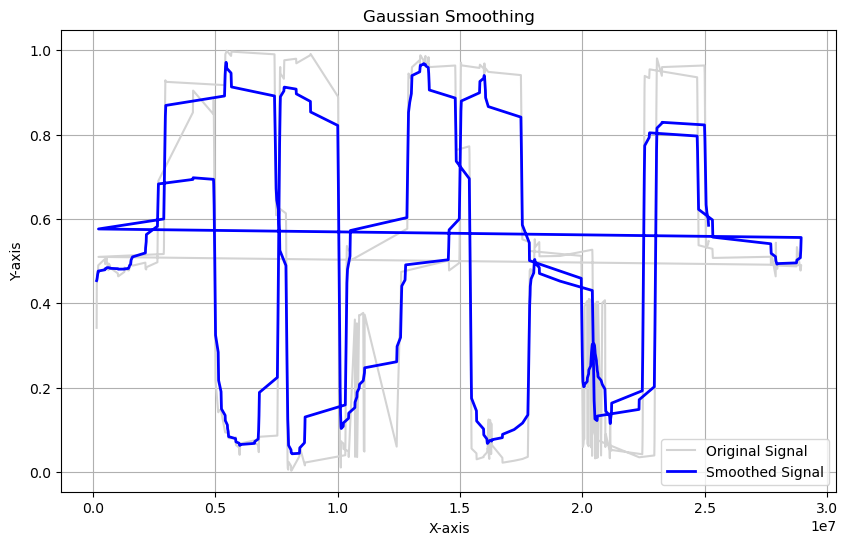

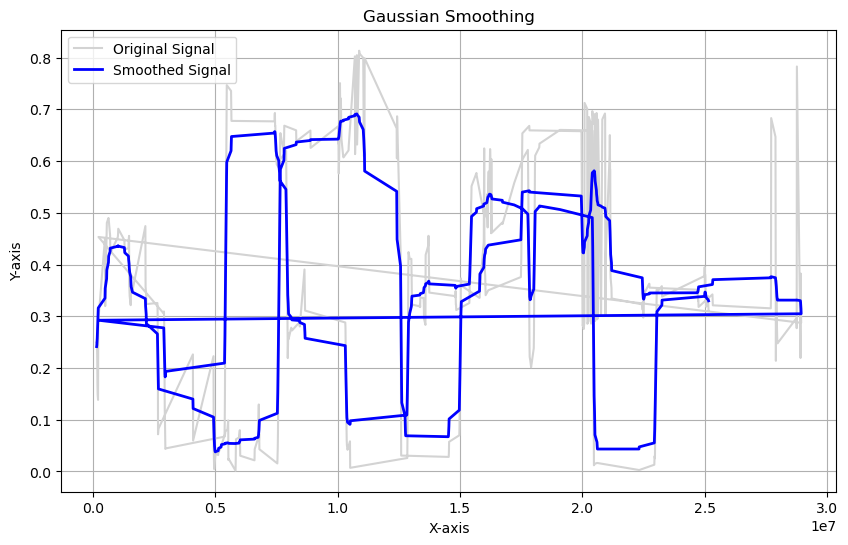

In [117]:
sigma = 5  # Standard deviation of the Gaussian kernel
y_smoothed = scipy.ndimage.gaussian_filter(dfSaccade['Gaze point X (MCSnorm)'], sigma=sigma)

plt.figure(figsize=(10, 6))

# Original signal
plt.plot(dfSaccade['Eyetracker timestamp'], dfSaccade['Gaze point X (MCSnorm)'], label='Original Signal', color='lightgray')

# Smoothed signal
plt.plot(dfSaccade['Eyetracker timestamp'], y_smoothed, label='Smoothed Signal', color='blue', linewidth=2)

plt.title('Gaussian Smoothing')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.show()

sigma = 5  # Standard deviation of the Gaussian kernel
y_smoothed = scipy.ndimage.gaussian_filter(dfSaccade['Gaze point Y (MCSnorm)'], sigma=sigma)

plt.figure(figsize=(10, 6))

# Original signal
plt.plot(dfSaccade['Eyetracker timestamp'], dfSaccade['Gaze point Y (MCSnorm)'], label='Original Signal', color='lightgray')

# Smoothed signal
plt.plot(dfSaccade['Eyetracker timestamp'], y_smoothed, label='Smoothed Signal', color='blue', linewidth=2)

plt.title('Gaussian Smoothing')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.show()

### Extracting relevant features from data metric

### TODO: Identify number of saccades in each AOI manually and where they are

In [131]:
saccade_metrics_location = defaultdict(int)
saccade_metrics_number = defaultdict(int)

columns_to_keep = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)', 
                          'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)']
for i in times_dict.keys():
    all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]

    total_saccades = 0
    df_saccades = pd.DataFrame()
    for index, row in all_possible_hits.iterrows(): 
        time = row['Eyetracker timestamp']
        #adding latency
        if (time/1000000 > (times_dict[i])+0.2) and (time/1000000 < (times_dict[i] + 2.5)):
            df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
#             entrySaccades[i] = index
        
            total_saccades +=1
    saccade_metrics_number[i] = total_saccades
    saccade_metrics_location[i] = df_saccades
  

saccade_metrics_location
saccade_metrics_number


/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_19434/4183515054.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_19434/4183515054.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_19434/4183515054.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_19434/4183515054.py:16: FutureWarning: The frame.append method is

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 29,
             'AOI hit [slothStimulus-final (1) - sloth2]': 10,
             'AOI hit [slothStimulus-final (1) - sloth3]': 23,
             'AOI hit [slothStimulus-final (1) - sloth4]': 2,
             'AOI hit [slothStimulus-final (1) - sloth5]': 17,
             'AOI hit [slothStimulus-final (1) - sloth6]': 8,
             'AOI hit [slothStimulus-final (1) - sloth7]': 1,
             'AOI hit [slothStimulus-final (1) - sloth8]': 5,
             'AOI hit [slothStimulus-final (1) - sloth9]': 6,
             'AOI hit [slothStimulus-final (1) - sloth10]': 4,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0,
             'AOI hit [catStimulus-final (1) - cat1]': 1,
             'AOI hit [catStimulus-final (1) - cat2]': 0,
             'AOI hit [catStimulus-final (1) - cat3]': 9,
             'AOI hit [catStimulus-final (1) - cat4]': 7,
             'AOI hit [catStimulus-final (1) - cat5]': 6,
     

In [8]:
# dataMetricSaccades = dataMetric.iloc[:,list(range(520, dataMetric.shape[1]))]


In [9]:
# dataMetricSaccades[['Number_of_saccades_in_AOI.bottomLeftCat1',
#        'Number_of_saccades_in_AOI.bottomLeftSloth',
#        'Number_of_saccades_in_AOI.bottomRightCat',
#        'Number_of_saccades_in_AOI.bottomRightCat2',
#        'Number_of_saccades_in_AOI.bottomRightSloth',
#        'Number_of_saccades_in_AOI.centerCat',
#        'Number_of_saccades_in_AOI.centerCat2',
#        'Number_of_saccades_in_AOI.centerSloth',
#        'Number_of_saccades_in_AOI.topCenterCat',
#        'Number_of_saccades_in_AOI.topCenterSloth',
#        'Number_of_saccades_in_AOI.topLeftCat',
#        'Number_of_saccades_in_AOI.topRightCat',
#        'Number_of_saccades_in_AOI.topRightSloth',
#        'Number_of_saccades_in_AOI.topRightSloth1',
#        'Time_to_entry_saccade.bottomLeftCat1']]

In [10]:
# dataMetricSaccades['Time_to_entry_saccade.centerCat2']